In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv(r'D:\Stock_trend_project\data\raw\train.csv')

sns.set()

unique_tickers = train['Ticker'].dropna().unique()
n_tickers_sample = 1000
sampled_tickers = np.random.choice(unique_tickers,
                                   size=min(n_tickers_sample, len(unique_tickers)),
                                   replace=False)

train_ticker_sample = train[train['Ticker'].isin(sampled_tickers)].copy()

train_ticker_sample['Date'] = pd.to_datetime(train_ticker_sample['Date'])

train_ticker_sample = train_ticker_sample.sort_values(['Ticker', 'Date'])

def sample_per_ticker(df, n_per_ticker=500):

    idx = np.linspace(0, len(df) - 1, num=min(n_per_ticker, len(df))).astype(int)
    return df.iloc[idx]

n_per_ticker = 500


eda_sample = (
    train_ticker_sample
    .groupby('Ticker', group_keys=True)
    .apply(sample_per_ticker, n_per_ticker=n_per_ticker, include_groups=False)
)
eda_sample = eda_sample.reset_index(level=0).rename(columns={"level_0": "Ticker"})


توزيع الأسعار عبر جميع الأسهم

توزيع أسعار الأسهم عبر جميع الأسطر وجميع الأسهم في الداتاسيت.
الهدف هو فهم:
- نطاق الأسعار (Minimum, Maximum).
- أماكن تركز القيم (Where most prices lie).
- وجود أي قيم شاذة أو ذيول طويلة في التوزيع (Outliers, Long Tails).

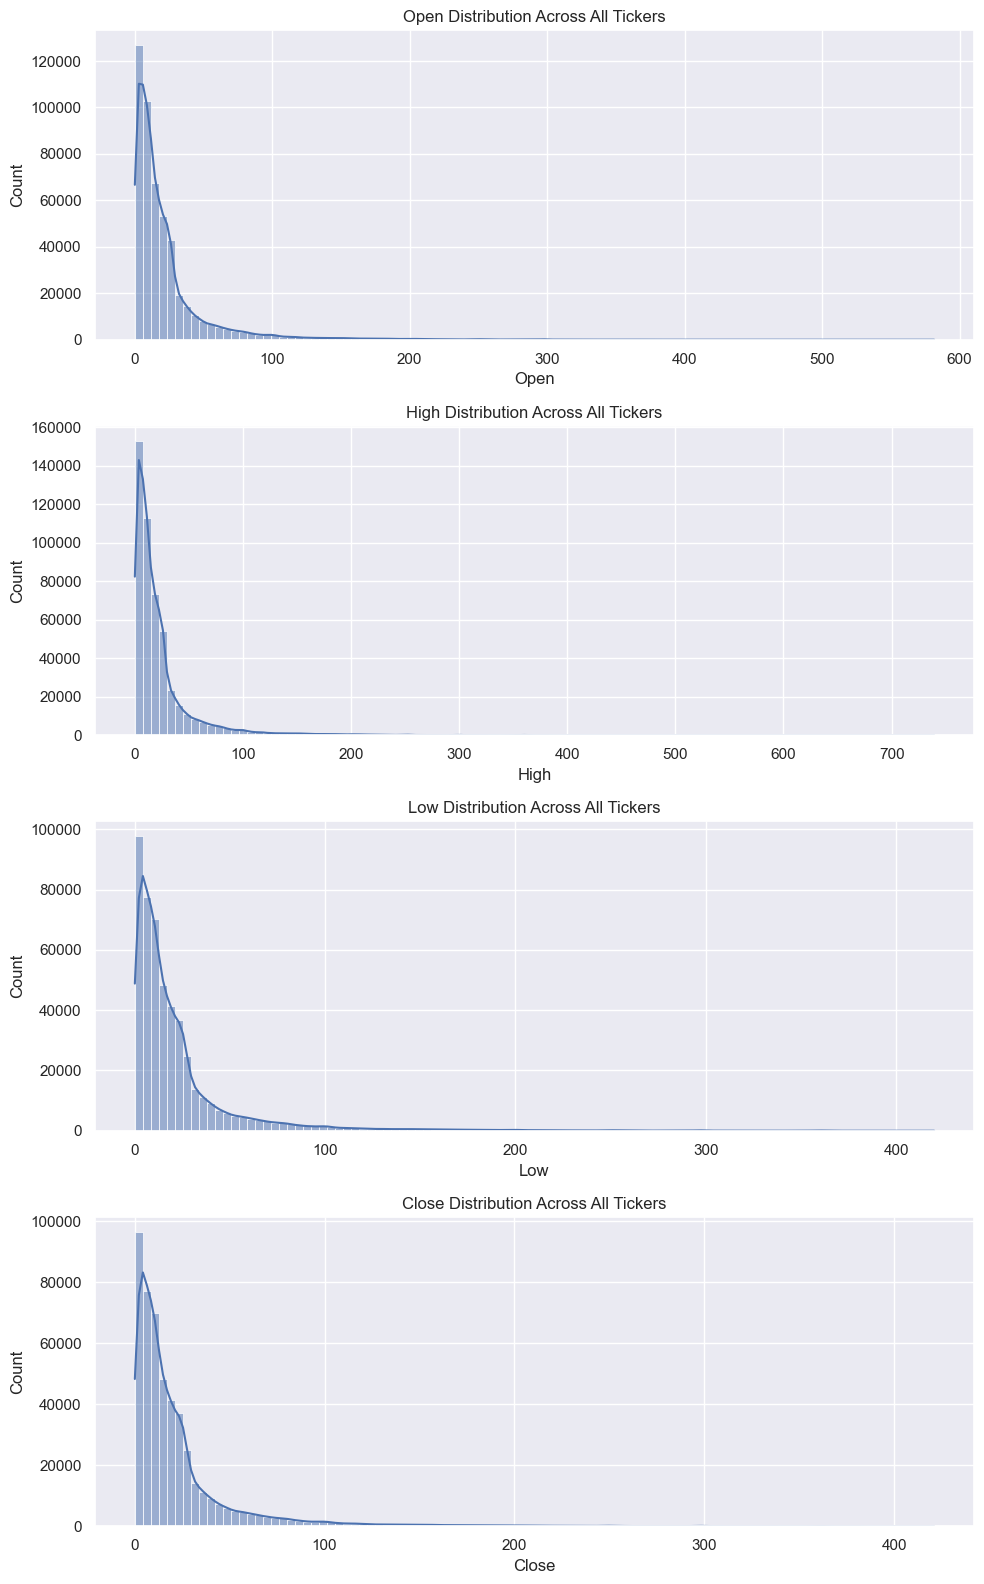

In [8]:


price_cols = ["Open", "High", "Low", "Close"]

fig, axes = plt.subplots(len(price_cols), 1, figsize=(10, 4*len(price_cols)))

for i, col in enumerate(price_cols):
    ax = axes[i]
    sns.histplot(
        data=eda_sample,
        x=col,
        bins=100,
        kde=True,
        ax=ax
    )
    ax.set_title(f"{col} Distribution Across All Tickers")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


Continuous Variables Analysis

Price distributions across all companies

This code reshapes the Open, High, Low, and Close columns into a long format and then plots a stacked histogram of the raw price values, colored by price type, to show how each type of price is distributed across all records and companies in the dataset.

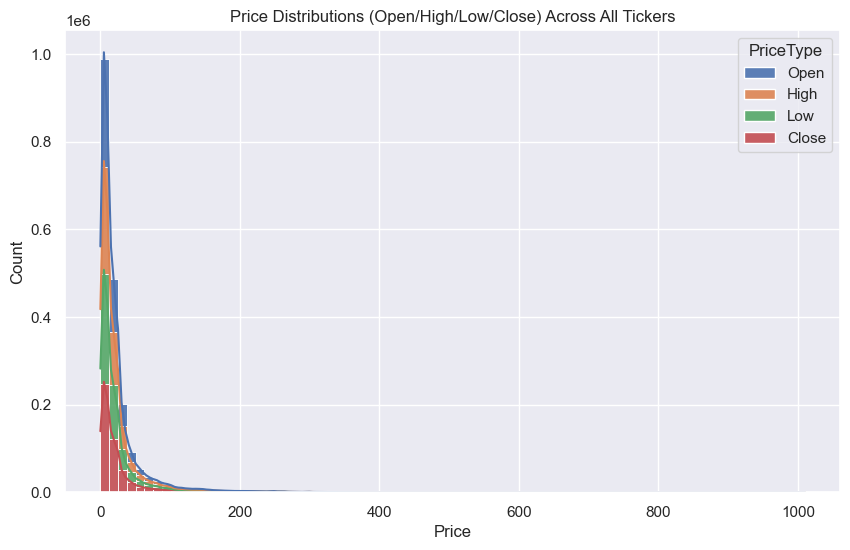

In [14]:

prices_long = eda_sample.melt(
    value_vars=price_cols,
    var_name="PriceType",
    value_name="Price"
)

plt.figure(figsize=(10, 6))
sns.histplot(
    data=prices_long,
    x="Price",
    hue="PriceType",
    bins=80,
    kde=True,
    multiple="stack",
    alpha=0.9,
)

plt.title("Price Distributions (Open/High/Low/Close) Across All Tickers")
plt.xlabel("Price")
plt.ylabel("Count")

plt.show()



## Extreme stock prices and outliers

In this section, I:
- Compute the global minimum and maximum prices across Open/High/Low/Close.
- Identify which tickers and dates correspond to these extreme price values.
- Visualize price outliers using a boxplot to see if there are unusually high or low prices that may need special handling in the model.


Global min price: 0.0
Global max price: 1010.0800170898438

Rows with global MAX price:


,Ticker,Date,Open,High,Low,Close
18490409,ticker_4784,2022-09-01,831.919983,1010.080017,328.0,419.200012



Rows with global MIN price:


,Ticker,Date,Open,High,Low,Close
65843,ticker_101,1973-05-02,0.0,0.475889,0.467834,0.475889
68885,ticker_101,1973-06-07,0.0,0.403391,0.364353,0.381084
71959,ticker_101,1973-07-16,0.0,0.472172,0.440570,0.472172
75050,ticker_101,1973-08-21,0.0,0.461082,0.451749,0.451749
78115,ticker_101,1973-09-27,0.0,0.507750,0.494683,0.502150


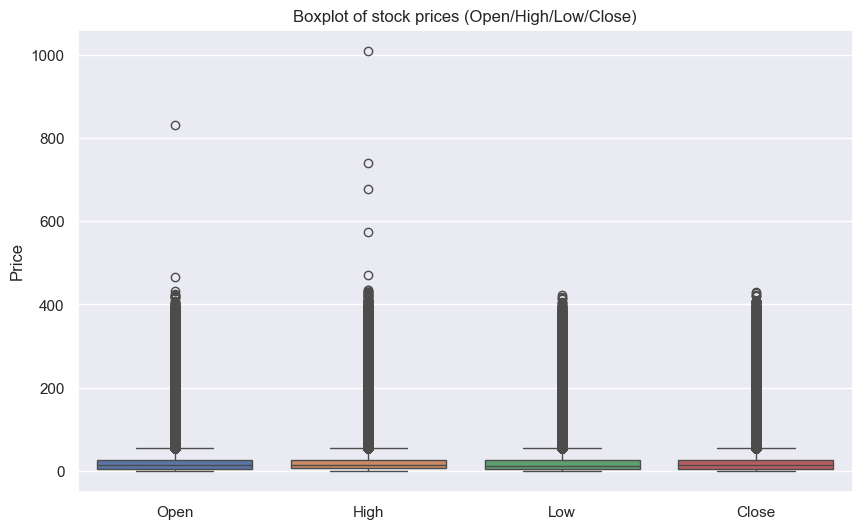

In [10]:

price_cols = ["Open", "High", "Low", "Close"]

global_min = eda_sample[price_cols].min().min()
global_max = eda_sample[price_cols].max().max()

print("Global min price:", global_min)
print("Global max price:", global_max)

high_price_mask = eda_sample[price_cols].max(axis=1) == global_max
low_price_mask  = eda_sample[price_cols].min(axis=1) == global_min

high_price_rows = eda_sample.loc[high_price_mask, ["Ticker", "Date"] + price_cols]
low_price_rows  = eda_sample.loc[low_price_mask,  ["Ticker", "Date"] + price_cols]

print("\nRows with global MAX price:")
display(high_price_rows.head())

print("\nRows with global MIN price:")
display(low_price_rows.head())

plt.figure(figsize=(10, 6))
sns.boxplot(data=eda_sample[price_cols])
plt.title("Boxplot of stock prices (Open/High/Low/Close)")
plt.ylabel("Price")
plt.show()

## Volume distribution and outliers

In this section:
- I analyze the distribution of trading volume using a **log-transformed** histogram `log(1 + Volume)` to handle the strong right skew.
- I use a **boxplot** on the raw `Volume` values to visually highlight extreme trading days.
- I compute IQR-based bounds to **count and inspect Volume outliers**, which may require special treatment before training the model.


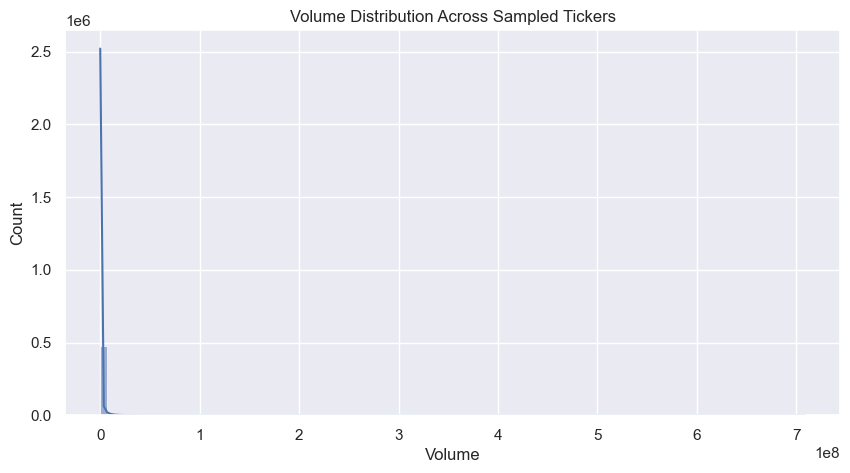

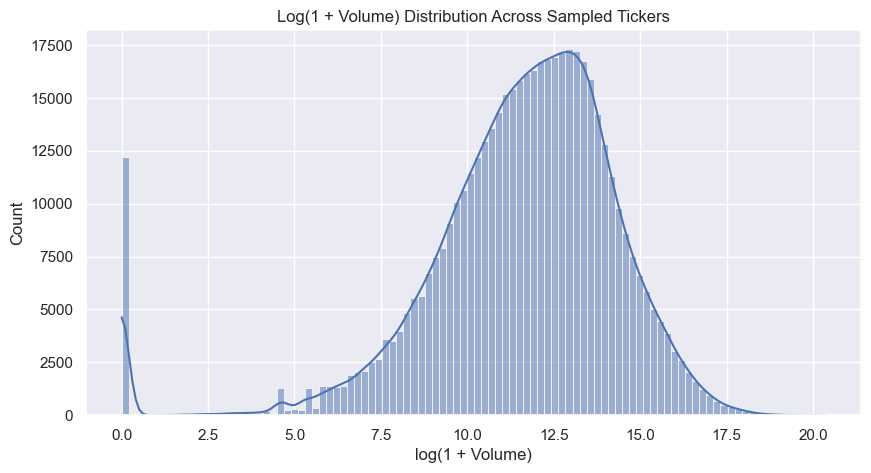

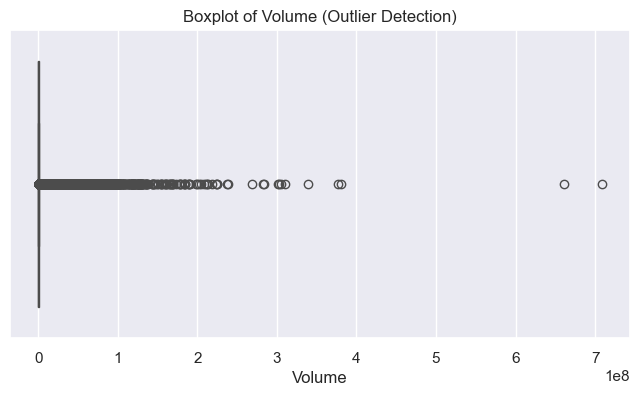

IQR-based Volume outliers count: 64228


,Ticker,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
7859806,ticker_1002,2008-11-03,31.383587,32.076336,30.669848,31.614504,2680000.0,0.0,0.0
7891634,ticker_1002,2008-11-24,31.078812,31.276364,30.133395,30.803654,2474700.0,0.0,0.0
7925634,ticker_1002,2008-12-16,28.736439,29.209148,28.362506,29.068041,1843100.0,0.0,0.0
8762403,ticker_1002,2010-06-17,43.707731,45.488718,43.612058,45.297371,2760300.0,0.0,0.0
13617802,ticker_1002,2017-08-24,98.279825,98.803982,93.413882,93.920570,5352400.0,0.0,0.0


In [14]:

plt.figure(figsize=(10, 5))
sns.histplot(
    x=np.log1p(eda_sample["Volume"]),
    bins=100,
    kde=True
)
plt.title("Log(1 + Volume) Distribution Across Sampled Tickers")
plt.xlabel("log(1 + Volume)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(
    x=eda_sample["Volume"]
)
plt.title("Boxplot of Volume (Outlier Detection)")
plt.xlabel("Volume")
plt.show()

q1 = eda_sample["Volume"].quantile(0.25)
q3 = eda_sample["Volume"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers_volume = eda_sample[
    (eda_sample["Volume"] < lower_bound) |
    (eda_sample["Volume"] > upper_bound)
]

print("IQR-based Volume outliers count:", len(outliers_volume))
display(outliers_volume.head())


### Daily price range vs. volume

Here I explored whether days with larger intraday price movement (`DailyRange = High - Low`) tend to have higher trading activity (`log(1 + Volume)`). The scatter plot shows a dense cloud near small ranges and a wide spread in volume, and the correlation (~0.13) is weakly positive. This suggests only a mild relationship between daily price range and volume, so this feature may add limited but not dominant signal to the model.


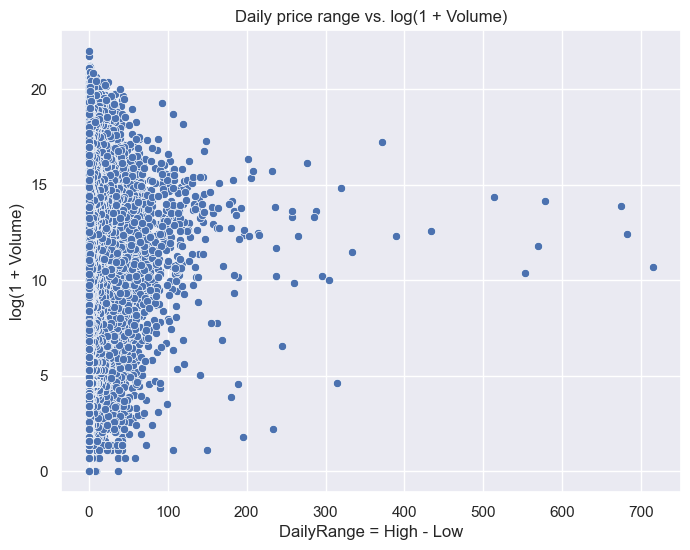

Correlation between DailyRange and log(1 + Volume): 0.13309440621794294


In [5]:

train["DailyRange"] =  train["High"] - train["Low"]

train[["DailyRange", "Volume"]].describe()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=train,
    x="DailyRange",
    y=np.log1p(train["Volume"])
)
plt.title("Daily price range vs. log(1 + Volume)")
plt.xlabel("DailyRange = High - Low")
plt.ylabel("log(1 + Volume)")
plt.show()

corr = train["DailyRange"].corr(np.log1p(train["Volume"]))
print("Correlation between DailyRange and log(1 + Volume):", corr)


Close price range per company

This code groups the data by company ticker, computes the minimum and maximum Close for each company, then derives a Close_range = max(Close) - min(Close) and plots a histogram of these ranges to show how widely closing prices move across different companies.

Summary of Close price ranges across tickers:


count    5000.000000
mean       69.373200
std        82.113117
min         0.000000
25%        15.293633
50%        36.195498
75%        89.441866
max       434.258344
Name: Close_range, dtype: float64

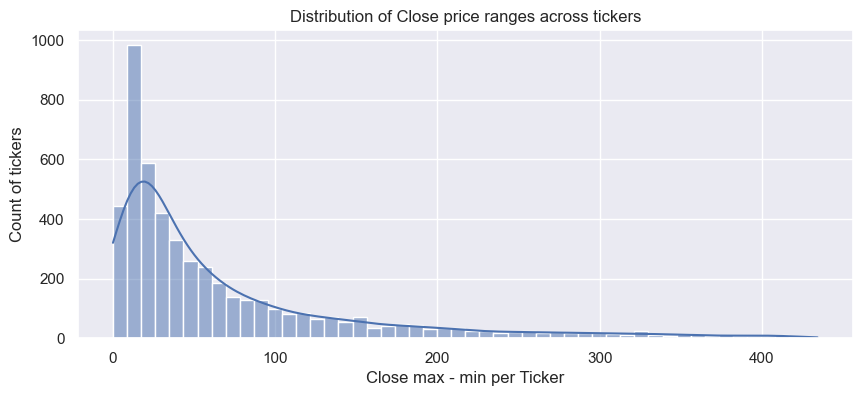

In [7]:
price_cols = ["Open", "High", "Low", "Close"]

price_ranges = (
    train
    .groupby("Ticker")[price_cols]
    .agg(["min", "max"])
)

price_ranges["Close_range"] = (
    price_ranges["Close"]["max"] - price_ranges["Close"]["min"]
)

print("Summary of Close price ranges across tickers:")
display(price_ranges["Close_range"].describe())

plt.figure(figsize=(10, 4))
sns.histplot(price_ranges["Close_range"], bins=50, kde=True)
plt.title("Distribution of Close price ranges across tickers")
plt.xlabel("Close max - min per Ticker")
plt.ylabel("Count of tickers")
plt.show()
